# Generative Models PHW4: Energy-Based Models

Name: Mohammad Mohammadi

Student ID: 402208592

## Setup

In [19]:
# Import necessary libraries
import random
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST

In [4]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


# Dataset (10 points)

Load the `MNIST` dataset and normalize the images between -1 and 1 as this makes the implementation easier.

In [5]:
# TODO: Define transformations and set the batch size
# normalizing from [0, 1] to [-1, 1] by using mean=0.5, std=0.5
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 128

# TODO: Load train and test datasets
trainset = MNIST(root='./data', train=True, download=True, transform=transform)
testset = MNIST(root='./data', train=False, download=True, transform=transform)

# TODO: Load the train and test loaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 13520758.76it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 342017.32it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3212826.33it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7921217.78it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Langevin Dynamics (20 points)

The Langevin dynamics in our case starts with a randomly initialized $x_0$ and then uses the information about the landscape of the energy function
(i.e., the gradient) to seek for new $x$, that is:
$$x_{t+1} = x_{t} + \alpha \nabla_{x_t}\text{LogSumExp} \left[f_{\theta} (x) \right] + \sigma \cdot \epsilon$$

where $\alpha, \sigma > 0$ and $\epsilon \sim \mathcal{N}(0, I)$. The Langevin dynamics could be seen as the stochastic gradient descent in the observable space with a small Gaussian noise added at each step.

Our goal is to run the Langevin dynamics for $\eta$ iterations with the steps size $\alpha$ and the noise level equal $\sigma$.

In [6]:
def energy_gradient(model, x):
    """
    Calculate dE/dx, where E(x) = -logsumexp(model outputs) 
    with respect to x. We do it under a 'with torch.enable_grad()' 
    block so that PyTorch won't ignore the gradient.
    """
    # Force gradient calculation inside this function
    with torch.enable_grad():
        # TODO: Set model to evaluation mode
        model.eval()

        # TDOO: Copy the original data and make it require gradients
        # x here is already on the correct device. We'll clone it and enable grad.
        x_ = x.clone().detach().requires_grad_(True)

        # Forward pass through the model
        # model(x_) returns logits of shape (batch_size, 10)
        logits = model(x_, None)  
        # E(x) = -logsumexp(logits)
        # We sum over the batch dimension so that autograd can handle the entire batch at once
        energy = -torch.logsumexp(logits, dim=1).sum()

        # TODO: Calculate the gradient
        # Calculate the gradient of E(x) with respect to x_
        energy.backward()

        # Extract the gradient (dE/dx)
        dE_dx = x_.grad.clone().detach()

        # If you want to ensure the model’s params do NOT get gradient from here:
        model.zero_grad()

        # TODO: Set model to training mode
        model.train()

    # TODO: Return the gradients
    return dE_dx


In [7]:
def langevin_dynamics_step(model, x, alpha, sigma):
    """
    x_{t+1} = x_t + alpha * dE/dx_t + sigma * epsilon
    Where dE/dx is the gradient of E with respect to x.
    """
    # TODO: Calculate gradient w.r.t. x
    grad = -energy_gradient(model, x)

    # TODO: Sample epsilon ~ Normal(0, I)
    epsilon = torch.randn_like(x).to(x.device)

    # TODO: Generatae a new sample
    x_new = x + alpha * grad + sigma * epsilon

    # Clip the samples to be in [-1, +1], optional but often helps stability
    # This ensures we stay within the valid range for images after transforms
    x_new = torch.clamp(x_new, -1, 1)

    # We detach so that each iteration’s x is a fresh leaf
    # So the partial derivatives stay local
    return x_new.detach()


# Sampling (15 points)

In [8]:
def sample(model, eta, alpha, sigma, batch_size=16):
    """
    Start with a random x in [-1, +1] and run Langevin dynamics for eta steps.
    Return the final samples.
    """
    # TODO: Sample x0 from uniform [-1, +1]
    x = (2.0 * torch.rand(batch_size, 1, 28, 28) - 1.0).to(device)

    # TODO: Run Langevin Dynamics η times
    for _ in range(eta):
        x = langevin_dynamics_step(model, x, alpha, sigma)

    # TODO: Return the result
    return x


# Loss (15 points)

We can evaluate our model using the following objective:

$$\mathcal{L} = \mathcal{L}_\text{clf}(\theta) + \mathcal{L}_\text{gen}(\theta)$$

Where $\mathcal{L}_\text{clf}(\theta)$ is the cross-entropy loss and $\mathcal{L}_\text{gen}(\theta)$ is an approximation to the log-marginal distribution over images (for example the LogSumExp loss).

In [9]:
def loss_function(model, eta, alpha, sigma, x, y_pred, y_true):
    """
    model: the energy-based model
    eta, alpha, sigma: parameters for the Langevin dynamics
    x: real images
    y_pred: logits from the model for real images
    y_true: ground truth labels for real images

    We define:
        L_clf = cross-entropy loss
        L_gen = E(x) - E(x_sample)

    Where E(x) = -logsumexp(model(x)), and x_sample is generated by the same model via sampling.
    """
    # TODO: Calculate the discriminative loss: the cross-entropy
    criterion = nn.CrossEntropyLoss()
    L_clf = criterion(y_pred, y_true)

    # TODO: Calculate the generative loss: E(x) - E(x_sample)
    # E(x_real) = -logsumexp( logits_real )
    E_real = -torch.logsumexp(y_pred, dim=1).mean()

    # Sample from the model
    # with torch.no_grad():
    #     x_fake = sample(model, eta, alpha, sigma, batch_size=x.size(0))
    x_fake = sample(model, eta, alpha, sigma, batch_size=x.size(0))
    x_fake = x_fake.detach()  # So no gradient flows back into x_fake steps
    logits_fake = model(x_fake, None)  # But do let the model see x_fake
    # E(x_fake) = -logsumexp( logits_fake )
    E_fake = -torch.logsumexp(logits_fake, dim=1).mean()

    # L_gen = E(x_real) - E(x_fake)
    L_gen = E_real - E_fake

    # TODO: Return the total loss
    return L_clf + L_gen


# Neural Network (10 points)

Define the neural network that specifies the energy function.
The inputs should be images and the outputs must be the classes.
Don't forget to use appropriate activation functions!

In [10]:
class EnergyNet(nn.Module):
    """
    A simple CNN that outputs logits for the 10 classes.
    We interpret E(x) = -logsumexp( logits(x) ) in the code.
    """
    def __init__(self):
        super(EnergyNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x, y=None):
        """
        We won't necessarily use y in the forward pass here,
        but we keep it in the signature for convenience with EBM-style code.
        """
        # x shape = (batch_size, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits


# Visualize (15 points)

Create the following functions to be able to visualize real and generated images.

In [11]:
def visualize_real(loader, n_images=8):
    """
    Visualize some real images from the loader.
    """
    images, labels = next(iter(loader))
    images = images[:n_images]
    labels = labels[:n_images]

    # Denormalize from [-1, 1] back to [0, 1] for plotting
    # If x in [-1, 1], then (x+1)/2 is in [0, 1].
    images_vis = (images + 1) / 2.0

    plt.figure(figsize=(12, 2))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(images_vis[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

def visualize_generated(model, eta, alpha, sigma, n_images=8):
    """
    Generate images via Langevin dynamics and visualize them.
    """
    with torch.no_grad():
        x_gen = sample(model, eta, alpha, sigma, batch_size=n_images)

    # Denormalize
    x_gen_vis = (x_gen + 1)/2.0

    plt.figure(figsize=(12, 2))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(x_gen_vis[i].squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle("Generated Samples")
    plt.show()


# Training (15 points)

Fill in the evaluation and training functions. Make sure you track the loss and plot it to analyze possible issues.

In [12]:
def eval_ebm(model, loader, eta, alpha, sigma):
    """
    Evaluate the model on the loader.
    Return the average cross-entropy loss and average accuracy.
    We won't do sampling inside eval, just the classification part.
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            logits = model(x, None)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)

            # Accuracy
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += x.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc

def train_ebm(model, optimizer, loader, epochs, eta, alpha, sigma):
    """
    Train the model on the loader for a number of epochs.
    We'll track the total loss (classifier + generative) over iterations.
    """
    model.train()
    loss_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            logits = model(x, y)

            # Compute the EBM loss (classifier + generative)
            loss = loss_function(model, eta, alpha, sigma, x, logits, y)

            # Backprop and update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)

        epoch_loss = running_loss / len(loader.dataset)
        loss_history.append(epoch_loss)

        # Print progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

    return loss_history


Now define the optimizer and train your model.

In [53]:
# TODO: Train your EBM
model = EnergyNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 5    # number of epochs 
eta = 10      # number of Langevin steps
alpha = 0.01  # step size
sigma = 0.005 # noise level

loss_history = train_ebm(model, optimizer, trainloader, epochs, eta, alpha, sigma)


Epoch [1/5], Loss: -263.9467
Epoch [2/5], Loss: -175.3737
Epoch [3/5], Loss: -343.0527
Epoch [4/5], Loss: -177.5086
Epoch [5/5], Loss: 29.1488


Plot the training curve.

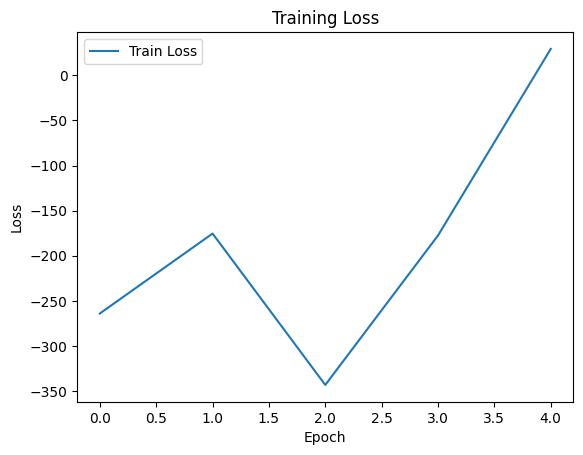

In [54]:
# TODO: Plot loss over epochs
plt.figure()
plt.plot(loss_history, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


Now visualize generated samples. (You can visualize images every few epochs to see the evolution of your network)

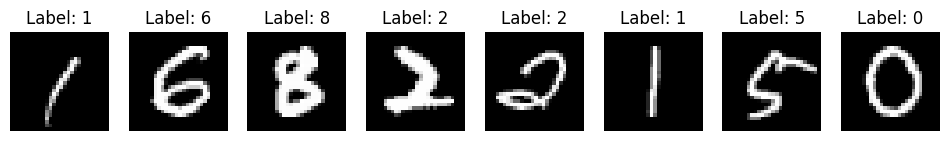

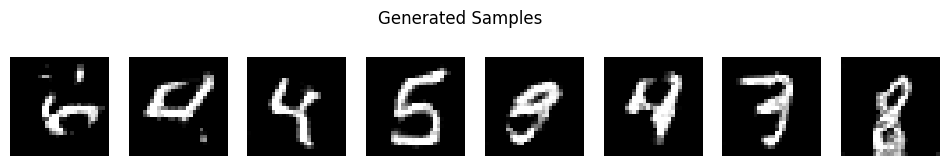

In [56]:
# TODO: Generate and visualize images

# First, visualize some real images:
visualize_real(trainloader)

# Now, visualize generated images
visualize_generated(model, eta, alpha, sigma)



In [16]:
# TODO: Train your EBM
model = EnergyNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

epochs = 100    # number of epochs 
eta = 20      # number of Langevin steps
alpha = 0.01  # step size
sigma = 0.005 # noise level

loss_history = train_ebm(model, optimizer, trainloader, epochs, eta, alpha, sigma)


Epoch [1/100], Loss: -2.2613
Epoch [2/100], Loss: -62.3566
Epoch [3/100], Loss: -268.0722
Epoch [4/100], Loss: -629.3091
Epoch [5/100], Loss: -939.6026
Epoch [6/100], Loss: -880.7765
Epoch [7/100], Loss: -633.5677
Epoch [8/100], Loss: -460.9649
Epoch [9/100], Loss: -341.7358
Epoch [10/100], Loss: -269.3146
Epoch [11/100], Loss: -235.1206
Epoch [12/100], Loss: -213.0519
Epoch [13/100], Loss: -202.7835
Epoch [14/100], Loss: -198.5113
Epoch [15/100], Loss: -199.3279
Epoch [16/100], Loss: -203.6024
Epoch [17/100], Loss: -202.6253
Epoch [18/100], Loss: -195.9399
Epoch [19/100], Loss: -187.4079
Epoch [20/100], Loss: -177.4563
Epoch [21/100], Loss: -161.2242
Epoch [22/100], Loss: -145.4163
Epoch [23/100], Loss: -132.1738
Epoch [24/100], Loss: -119.3972
Epoch [25/100], Loss: -109.6080
Epoch [26/100], Loss: -103.3107
Epoch [27/100], Loss: -99.1687
Epoch [28/100], Loss: -95.2353
Epoch [29/100], Loss: -90.3641
Epoch [30/100], Loss: -88.1687
Epoch [31/100], Loss: -89.2403
Epoch [32/100], Loss: -84

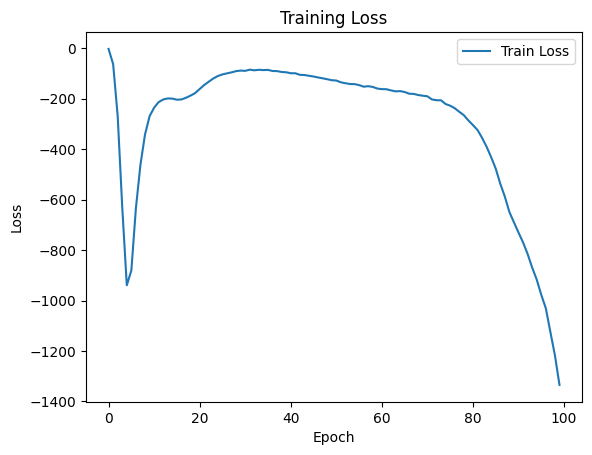

In [17]:
# TODO: Plot loss over epochs
plt.figure()
plt.plot(loss_history, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


If your resutls aren't great you can tune the hyperparameters to get better results or alternatively you can modify the dataset (resize, ...)to make it easier to learn the energy function.

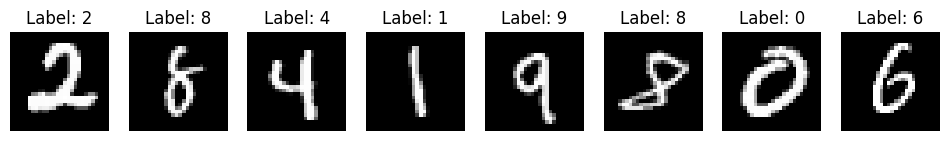

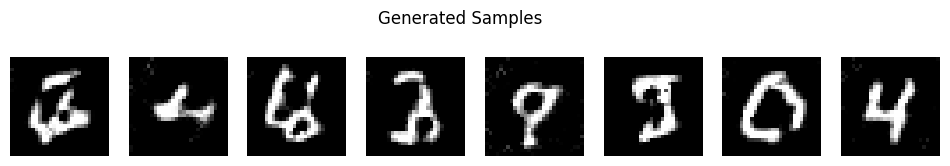

In [18]:
# TODO: Generate and visualize images

# First, visualize some real images:
visualize_real(trainloader)

# Now, visualize generated images
visualize_generated(model, eta, alpha, sigma)

